## Import libraries

In [1]:
from models.model_v2 import *
from data.midi_preprocessing import *
from utils.dataset_loader import MaestroV3DataModule, MaestroV3DataSet

/usr/lib/python3.13/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Loss callback

In [2]:
# Callback to track the loss of the minmax game.
class LossTracker(L.Callback):
    def __init__(self):
        self.g_losses = []
        self.d_losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
    #def on_train_epoch_end(self, trainer, pl_module):
        g_loss = trainer.callback_metrics.get("g_loss")
        d_loss = trainer.callback_metrics.get("d_loss")
        self.g_losses.append(g_loss.item())
        self.d_losses.append(d_loss.item())

    def plot(self):
        display.clear_output(wait=True)
        plt.plot(self.g_losses, label="Generator Loss")
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Losses")
        plt.legend()
        plt.grid(True)
        plt.show()

## Train the model

In [5]:
# Create the GAN.
model = GAN(apply_mbd=False)

# Dataset.
data_file_path = "data/preprocessed/maestro-v3.0.0/dataset2/50K_dataset.h5"
dm = MaestroV3DataModule(data_file_path, mode="pair")

# LossTracker.
loss_tracker = LossTracker()

# Define the trainer.
trainer = L.Trainer(
    #enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=3,
    callbacks=[loss_tracker]
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 502 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
748 K     Trainable params
0         Non-trainable params
748 K     Total params
2.996     Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1540/1540 [01:55<00:00, 13.29it/s, v_num=385, d_loss=0.518, g_loss=3.600]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1540/1540 [01:55<00:00, 13.29it/s, v_num=385, d_loss=0.518, g_loss=3.600]


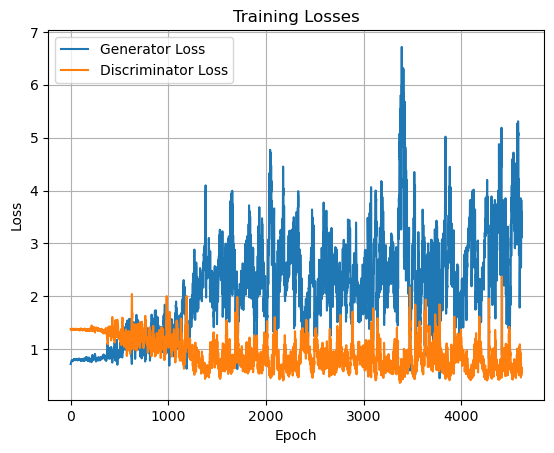

In [7]:
# Plot generator and discriminator losses.
loss_tracker.plot()

## Testing

In [8]:
import random

# Define the dataset.
dataset = MaestroV3DataSet(data_file_path, mode="pair")

# Random index.
rnd_idx = random.randint(0, len(dataset))

# Choose the first random sample from the dataset.
bar_0, _ = dataset[rnd_idx] # [1, 128, 16]
bar_0 = bar_0.unsqueeze(0)
print(bar_0.shape)

torch.Size([1, 1, 128, 16])


In [9]:
# Set model in evaluation.
model.eval()

# Generate noise.
noise = torch.randn(7, 1, 100)

#for z in noise:
#    print(z.shape)

# Generate 8 bar.
bars = [bar_0]
for i, z in enumerate(noise):
    # Previous bar.
    prev = bars[i-1]

    # Create the pair.
    x = z, prev

    # Generate current bar.
    curr = model(x)

    # Save genjerated bar
    bars.append(curr)

In [10]:
# Convert bars in numpy array.
bars_numpy = []
for bar in bars:
    bar = bar.squeeze(0, 1).detach().numpy()
    #print(bar.shape)
    bars_numpy.append(bar)

Bar 0


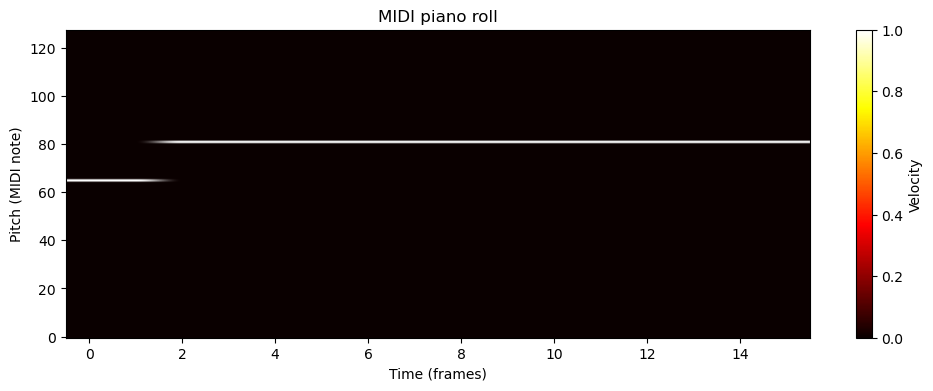

Bar 1


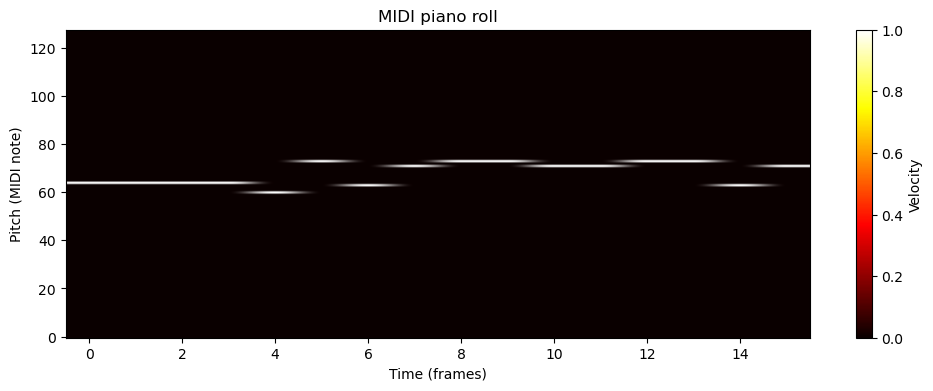

Bar 2


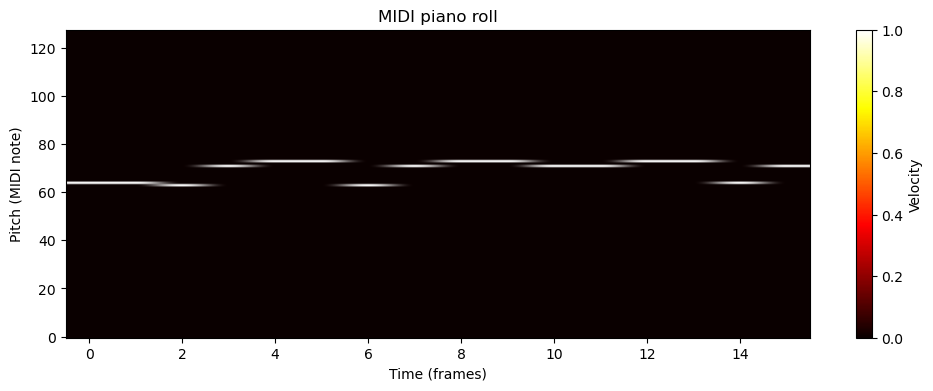

Bar 3


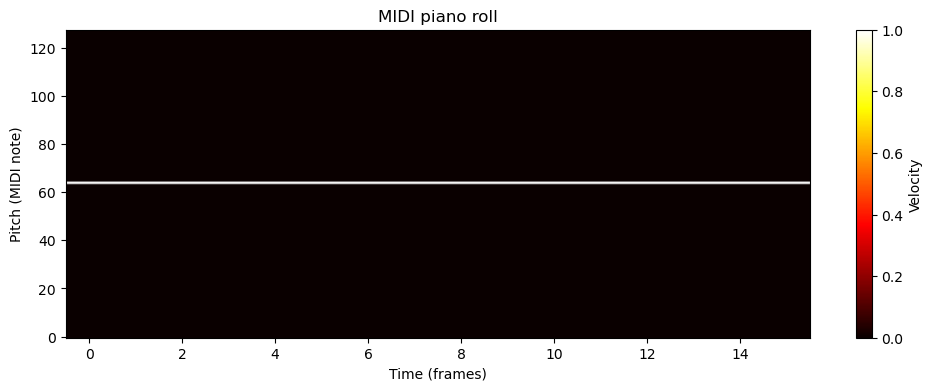

Bar 4


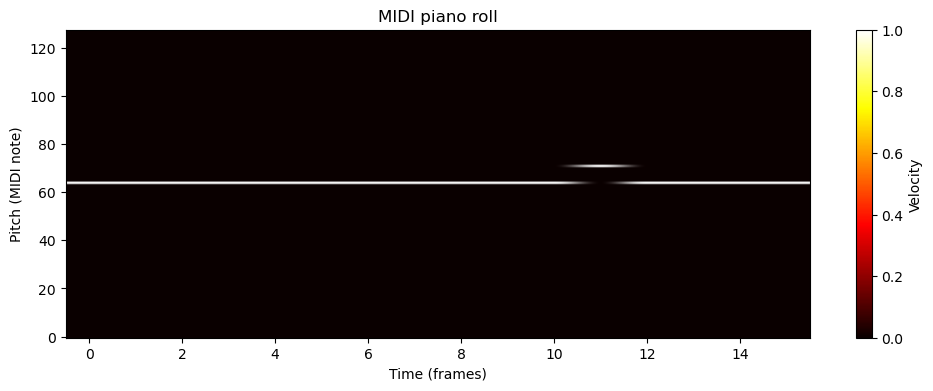

Bar 5


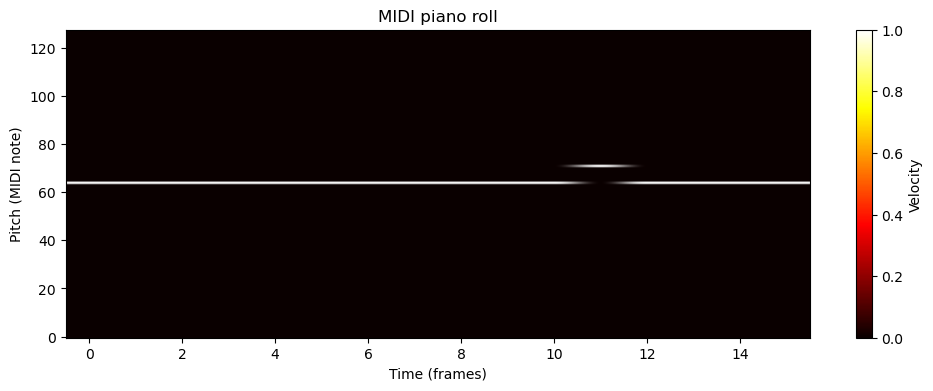

Bar 6


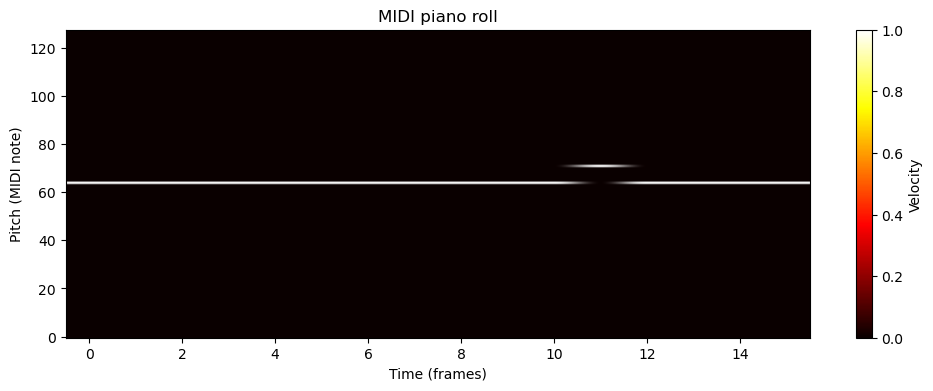

Bar 7


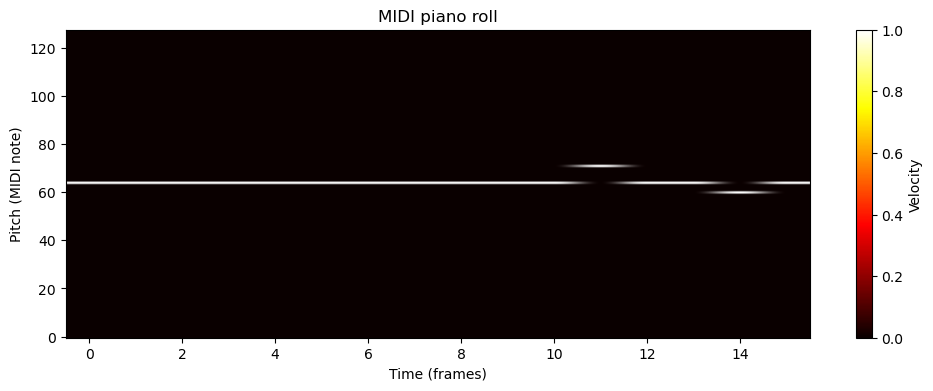

In [11]:
# Plot each single bar.
for i, bar in enumerate(bars_numpy):
    print("Bar", i)
    show_piano_roll(bar)

Full piano roll
Shape: (128, 128)


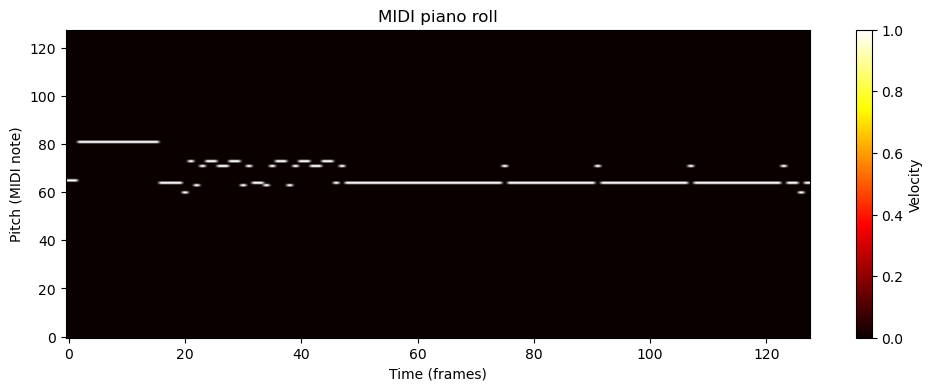

In [12]:
# Create the full piano roll.
full_piano_roll = np.hstack([bar for bar in bars_numpy])
print("Full piano roll")
print("Shape:", full_piano_roll.shape)
show_piano_roll(full_piano_roll)

# Multiply by 50.
full_piano_roll *= 50

In [13]:
# Create the output midi file.
pm = piano_roll_to_pretty_midi(full_piano_roll, fs=8)
output_fn = "output_test.midi"
pm.write(output_fn)